# Predicting Apartment Prices in Mexico City

<div style = "display: flex-direction: row;">
    <img src="https://upload.wikimedia.org/wikipedia/commons/6/6b/Mexico_City_Reforma_Street.jpg" alt="Mexico City" style = "width:95%; margin-right: 5px;">

</div>

In this project, we aim to predict apartment prices in Mexico City using machine learning techniques. By analyzing various features such as location, size, amenities, and more, we can build a predictive model to estimate housing prices.

### Project Goals:
- Clean prepare real estate data for Mexico City.
- Explore and visualize the data to gain insights.
- Engineer relevant features for modeling.
- Train and evaluate machine learning models for price prediction.

Let's dive into the exciting world of data science and housing market analysis in Mexico City!

#### importing Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error,mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
#import mysql.connector
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor


In [3]:
#!pip install category_encoders

#### Preparing the Data

##### Importing


## Function: `data_wrangler`

This function performs several data preprocessing steps to clean and prepare the dataset:

1. **Load Data:**
   - Takes a file path as input and loads the dataset.

2. **Drop Index Column:**
   - Removes the 'Unnamed: 0' column, assumed to be the index column.

3. **Split Latitude and Longitude:**
   - Splits the 'lat-lon' column into separate 'latitude' and 'longitude' columns.

4. **Extract Borough and City:**
   - Extracts 'borough' and 'city' information from the 'place_with_names' column.

5. **Filter Data:**
   - Subsets the data to include only apartments in Mexico City ("Distrito Federal") with prices less than $100,000.

6. **Drop Columns:**
   - Removes columns with the following criteria:
     - More than 50% null values
     - Categorical columns with high or low cardinality
     - Leaking columns (columns that may leak information about the target)

7. **Remove Outliers:**
   - Uses information from the 'area' column to guide the removal of outliers.

8. **Return Cleaned DataFrame:**
   - Returns the cleaned DataFrame after performing all the above operations.

This structured approach ensures that the data wrangling process is clear and follows a systematic workflow, making it easier to understand and maintain.



In [4]:
def data_wrangler(path):
    df = pd.read_csv(path)
    
    #spliting lat-lon
    df[['lat', 'lon']] = df['lat-lon'].str.split(',', expand=True).astype(float)

    #Extracting the city, borough
    df[['borough', 'city']] = df['place_with_parent_names'].str.split('|', expand=True)[[1,2]]

    #Subsetting the data by apartments in Mexico City ("Distrito Federal") that cost less than $100,000.
    df = df[
        (df['city'] == 'Distrito Federal') &
        (df['property_type'] == 'apartment') &
        (df['price_aprox_usd'] < 100000)
    ]
    
    #Removing the Outliers i.e top and bottom 10%  of surface_cov_in m2
    area_lower_limit = df['surface_covered_in_m2'].quantile(0.1)
    area_upper_limit = df['surface_covered_in_m2'].quantile(0.9)
    df = df[
        (df['surface_covered_in_m2'] >=area_lower_limit) &
        (df['surface_covered_in_m2'] <= area_upper_limit)
    ]    

    #Initiating cols to be dropped list the indexing column
    cols_drop = ['Unnamed: 0', 'lat-lon', 'place_with_parent_names']


    #identifying Cols with more 50% null Values
    null_col = [col for col in df.columns if df[col].isnull().sum() > 0.5*len(df)]
    cols_drop.extend(null_col)

    #Cols with High and Low Cardinality
    high_low_cardi = [col for col,n in df.select_dtypes(include='object').nunique().items() if n <= 2 or n >= 0.75*len(df)]
    cols_drop.extend(high_low_cardi)

    #Cols causing leaks
    cols_leak = [col for col in df.columns if col.lower().startswith('price') and not col.lower().endswith('usd')]
    cols_drop.extend(cols_leak)
    # Dropping unnecessary cols

    ver_cols_drop = [col for col in cols_drop if col in df.columns] #Verifying cols to be dropped
    df.drop(columns= ver_cols_drop, inplace= True)            

    return df

#### Loading the entire datasets and merging them into one 

In [5]:
##Getting file paths for the datasets
files = glob.glob('./data/mexico*[0-9].csv')

#processing them and storing into a list
dfs = [data_wrangler(file) for file in files]

#Concating 
mexico_df = pd.concat(dfs)

mexico_df.head()
mexico_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5473 entries, 11 to 4618
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        5473 non-null   float64
 1   surface_covered_in_m2  5473 non-null   float64
 2   lat                    5149 non-null   float64
 3   lon                    5149 non-null   float64
 4   borough                5473 non-null   object 
dtypes: float64(4), object(1)
memory usage: 256.5+ KB


In [6]:
mexico_df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,borough
11,94022.66,57.0,23.634501,-102.552788,Benito Juárez
20,70880.12,56.0,19.402413,-99.095391,Iztacalco
21,68228.99,80.0,19.357820,-99.149406,Benito Juárez
22,24235.78,60.0,19.504985,-99.208557,Azcapotzalco
26,94140.20,50.0,19.354219,-99.126244,Coyoacán


### Exploring the data

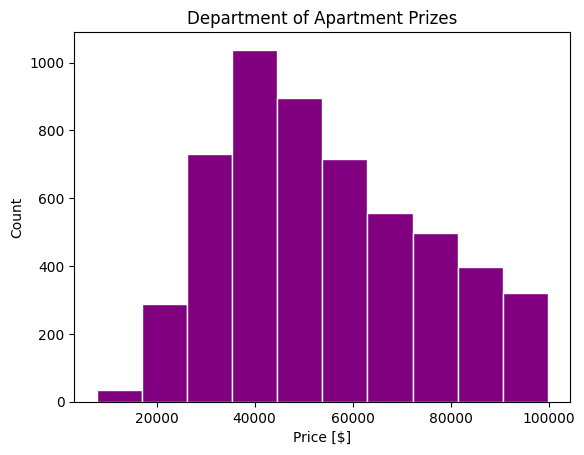

In [7]:
#Distribution of House Prices
plt.hist(mexico_df['price_aprox_usd'], color = 'purple', edgecolor = 'white')

#Labeling
plt.xlabel('Price [$]')
plt.ylabel('Count')
plt.title('Department of Apartment Prizes')

plt.show()

#### Splitting the data into train and Test, target and feature

In [8]:
target = 'price_aprox_usd'
y = mexico_df[target]
X = mexico_df.drop(columns = target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
X_train.head()

,surface_covered_in_m2,lat,lon,borough
3584,70.0,19.485524,-99.210631,Azcapotzalco
4305,60.0,19.370272,-99.149127,Benito Juárez
226,85.0,19.426948,-99.106956,Venustiano Carranza
3883,50.0,19.302219,-99.049311,Tláhuac
2535,51.0,19.350829,-99.081762,Iztapalapa


#### Developing the model
It will have :
- SimpleImputer 
- OneHotEncoder 
- random forest

In [10]:
model = make_pipeline(
    OneHotEncoder(use_cat_names= True),
    SimpleImputer(),
    RandomForestRegressor(random_state=42, n_estimators=200)
)

# fitting the model
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['borough'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=200, random_state=42))])

#### Evaluating the model

In [11]:
y_pred = model.predict(X_test)
y_pred

array([31981.60292333, 38676.58493726, 40718.29526881, ...,
       51235.61265417, 50205.27305   , 34952.24150705])

In [12]:
mae = mean_absolute_error(y_test, y_pred)
soe = sum(y_pred - y_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Metrics:\nMAE: {mae:.2f}\nMSE: {mse:.2f}\nR2: {r2:2%}\nSum of Errors: {soe:.2f}")

Metrics:
MAE: 7557.13
MSE: 138493482.01
R2: 68.083574%
Sum of Errors: 1039411.70


In [27]:
for i in range(100,500,100):
    for j in range(1, 10):
        j /= 10
        model = make_pipeline(
            OneHotEncoder(use_cat_names= True),
            SimpleImputer(),
            GradientBoostingRegressor(random_state=42, n_estimators=i, learning_rate=j)
        )

        # fitting the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        soe = sum(y_pred - y_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"*******NO OF TREES {i} ******\n\t******Learning Rate {j} *****\nMetrics:\nMAE: {mae:.2f}\nMSE: {mse:.2f}\nR2: {r2:2%}\nSum of Errors: {soe:.2f}")


*******NO OF TREES 100 ******
	******Learning Rate 0.1 *****
Metrics:
MAE: 12688.56
MSE: 243605289.60
R2: 43.860100%
Sum of Errors: 399853.24
*******NO OF TREES 100 ******
	******Learning Rate 0.2 *****
Metrics:
MAE: 11481.81
MSE: 211018821.01
R2: 51.369794%
Sum of Errors: 488698.03
*******NO OF TREES 100 ******
	******Learning Rate 0.3 *****
Metrics:
MAE: 10893.91
MSE: 195068497.72
R2: 55.045615%
Sum of Errors: 499046.32
*******NO OF TREES 100 ******
	******Learning Rate 0.4 *****
Metrics:
MAE: 10486.24
MSE: 190665950.84
R2: 56.060201%
Sum of Errors: 484649.80
*******NO OF TREES 100 ******
	******Learning Rate 0.5 *****
Metrics:
MAE: 10201.86
MSE: 184616306.85
R2: 57.454368%
Sum of Errors: 483681.63
*******NO OF TREES 100 ******
	******Learning Rate 0.6 *****
Metrics:
MAE: 9935.91
MSE: 180807164.70
R2: 58.332201%
Sum of Errors: 416203.59
*******NO OF TREES 100 ******
	******Learning Rate 0.7 *****
Metrics:
MAE: 9708.55
MSE: 179836120.17
R2: 58.555983%
Sum of Errors: 374789.73
*******N

In [13]:
for j in range(1, 10):
    j /= 10
    print(j)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [14]:
for j,i in range(4),range(7):
    print (i+j)

ValueError: too many values to unpack (expected 2)